## About

This page showcases the work of [Jan Kühn](https://yotka.org) published as a web app called [MeteoHist](https://yotka.org/meteo-hist/). It can be used to create **Area over flexible baseline charts** for temperature and precipitation data. The code has been published on [GitHub](https://github.com/yotkadata/meteo_hist).

The simplified example presented here, shows step by step how to use historical temperature data from [open-meteo.com](https://open-meteo.com/en/docs/historical-weather-api) to **compare a given year to the mean and percentile values of a reference period**. The plot is created using the `Plotly` library in `Python`.

## Import modules

First, we import the modules we need.

In [41]:
import datetime as dt
from calendar import isleap

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import requests
from plotly.express.colors import sample_colorscale
from statsmodels.nonparametric.smoothers_lowess import lowess

## Get the data

For this plot, we use data from the [Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api) provided by open-meteo.com. It is based on data from reanalysis datasets the European Union's Copernicus Programme. The data can be downloaded using a simple API call.

In this example, we will be using coordinates of **Addis Ababa, Ethiopia** and **mean temperature** two meters above the ground to compare the values of 2022 to the reference period 1961-1990.

In [42]:
# Define values to get mean temperature data from API
lat, lon = 9.035845, 38.752406
date_start = "1961-01-01"
date_end = "2022-12-31"
metric_data = "temperature_2m_mean"
units = "celsius"

# Construct the API URL
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}&"
    f"start_date={date_start}&end_date={date_end}&"
    f"daily={metric_data}&timezone=auto"
    f"&temperature_unit={units}"
)

# Get the data from the API
data = requests.get(url, timeout=30)

# Create new Dataframe from column "daily"
df_raw = pd.DataFrame(
    {"date": data.json()["daily"]["time"], "value": data.json()["daily"][metric_data],}
)

# Convert date column to datetime
df_raw["date"] = pd.to_datetime(df_raw["date"])

Have a look at the data:

In [43]:
df_raw

,date,value
0,1961-01-01,12.3
1,1961-01-02,13.4
2,1961-01-03,13.3
3,1961-01-04,12.8
4,1961-01-05,12.8
...,...,...
22640,2022-12-27,14.8
22641,2022-12-28,13.5
22642,2022-12-29,12.9
22643,2022-12-30,12.7


## Transform data

Next, we have to apply some transformations. For the plot we need a dataframe with one row for each day of the year and columns holding the following values:

- `dayofyear`: Day of the year (integer from 1 to 365, without leap days)
- `p05`: (Smoothed) 5th percentile of the reference period data
- `mean`: (Smoothed) mean of the reference period data
- `p95`: (Smoothed) 95th percentile of the reference period data
- `2022`: Temperature value for the year we compare (in this case 2022)
- `2022_diff`: Difference of the current year's value to the mean
- `2022_alpha`: Opacity values (0.6 if year's value is between p05 and p95, else 1)
- `date`: Datetime object of the day

In [44]:
# Define year and reference period
year = 2022
reference_period = (1961, 1990)

# Create a copy of the raw dataframe
df_f = df_raw.copy()

# Add column with day of year
df_f["dayofyear"] = df_f["date"].dt.dayofyear

# Remove all Feb 29 rows to get rid of leap days
df_f = df_f[~((df_f["date"].dt.month == 2) & (df_f["date"].dt.day == 29))].copy()

# Adjust "dayofyear" values for days after February 29th in leap years
df_f["dayofyear"] = df_f["dayofyear"].where(
    ~((df_f["date"].dt.month > 2) & (df_f["date"].dt.is_leap_year)),
    df_f["dayofyear"] - 1,
)

# Reset index
df_f.reset_index(drop=True, inplace=True)

# Filter dataframe to reference period
data = df_f[df_f["date"].dt.year.between(*reference_period)].copy()

# Group by day of year and calculate 5th percentile, mean, and 95th percentile
data = (
    data.groupby("dayofyear")["value"]
    .agg(
        [
            ("p05", lambda x: np.nanpercentile(x, 5)),
            ("mean", "mean"),
            ("p95", lambda x: np.nanpercentile(x, 95)),
        ]
    )
    .reset_index()
)

# Add smoothing using LOWESS (Locally Weighted Scatterplot Smoothing)
# to the 5th percentile, mean, and 95th percentile
for col in ["p05", "mean", "p95"]:
    smoothed_values = lowess(
        data[col],
        data["dayofyear"],
        is_sorted=True,
        # Fraction of data used when estimating each y-value
        # 1/12 roughly equals one month (= a lot of smoothing)
        frac=1 / 12,
    )

    data[col] = smoothed_values[:, 1]

# Add column with year's value
data[f"{year}"] = df_f[df_f["date"].dt.year == year]["value"].reset_index(drop=True)

# Add column that holds the difference between the year's value and the mean
data[f"{year}_diff"] = data[f"{year}"] - data["mean"]

# Add column that holds alpha values for the year's value to highlight outliers
# Values between the 5th and 95th percentile get reduced opacity of 60% (0.6)
data[f"{year}_alpha"] = data.apply(
    lambda x: 1 if x[f"{year}"] > x["p95"] or x[f"{year}"] < x["p05"] else 0.6, axis=1,
).fillna(0)

# Add date column
# If given year is a leap year, this has to be accounted for
# by adding 1 to the day of year after February 28th
dayofyear = data["dayofyear"]

if isleap(year):
    dayofyear = data["dayofyear"].where(
        data["dayofyear"] < 60, other=data["dayofyear"] + 1
    )

data["date"] = dayofyear.apply(
    lambda x: dt.datetime(year, 1, 1) + dt.timedelta(days=x - 1)
)

Have a look at the dataframe:

In [45]:
data

,dayofyear,p05,mean,p95,2022,2022_diff,2022_alpha,date
0,1,11.252559,13.130396,14.814301,16.6,3.469604,1.0,2022-01-01
1,2,11.322329,13.175637,14.847490,17.5,4.324363,1.0,2022-01-02
2,3,11.392410,13.220881,14.880949,16.0,2.779119,1.0,2022-01-03
3,4,11.462678,13.266079,14.914659,15.1,1.833921,1.0,2022-01-04
4,5,11.533004,13.311186,14.948560,15.3,1.988814,1.0,2022-01-05
...,...,...,...,...,...,...,...,...
360,361,11.675899,13.272582,14.799901,14.8,1.527418,1.0,2022-12-27
361,362,11.695305,13.285921,14.816865,13.5,0.214079,0.6,2022-12-28
362,363,11.714921,13.299838,14.834247,12.9,-0.399838,0.6,2022-12-29
363,364,11.734664,13.314251,14.852072,12.7,-0.614251,0.6,2022-12-30


## Create the plot

Now that we transformed the data, we can start creating the plot. First, we define a figure with some basic settings. We'll extend them later.

In [46]:
# Create a new Figure object with some basic layout
fig = go.Figure(
    layout=go.Layout(
        template="plotly_white",
        title={
            "text": (
                f"<b>Mean temperature in Addis Ababa {year}</b><br />"
                f"<sup>Compared to historical daily mean temperatures "
                f"({reference_period[0]}-{reference_period[1]})</sup>"
            ),
        },
        width=1000,
        height=600,
        font={"family": "Lato", "size": 14, "color": "#1f1f1f"},
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        hovermode="x",
    )
)

## Plot percentile area

In Plotly the order of traces determines their position (abov/below). That's why we first plot the area between the 5/95 percentiles, then daily values for the year to display, and then percentile lines and mean (on top). 

It's also possible to reorder the traces later, but this way we get it right from the beginning.

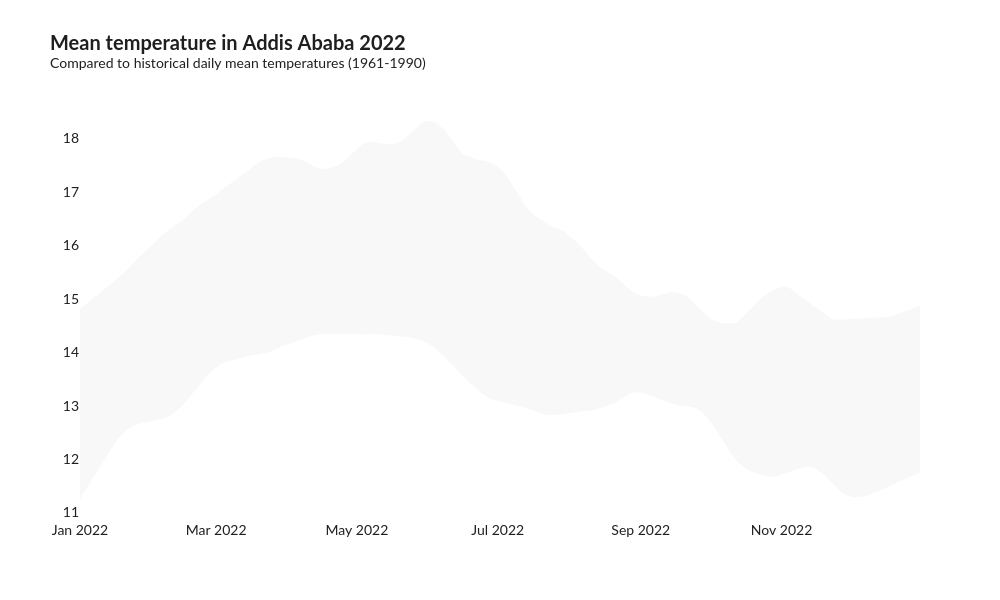

In [47]:
fig.add_traces(
    [
        # p95 trace used as upper bound. This is needed to fill the area between
        # the p05 and p95 traces using the "tonexty" fill option
        go.Scatter(
            x=data["date"],
            y=data["p95"],
            name="Percentile area upper bound (p95)",
            # Make line invisible
            line_color="rgba(0,0,0,0)",
            showlegend=False,
            hoverinfo="skip",
        ),
        # Fill area between p05 and p95
        go.Scatter(
            x=data["date"],
            y=data["p05"],
            name="Area between p05 and p95",
            # Fill area between this trace and the one above
            fill="tonexty",
            fillcolor="#f8f8f8",
            # Make line invisible
            line_color="rgba(0,0,0,0)",
            showlegend=False,
            hoverinfo="skip",
        ),
    ]
)

fig.show("png")

## Plot daily values for the given year

For each day of the year, we now add an area that starts from the mean and goes up/down to the daily value. Basically, this could be done in one trace using the `fill="tonexty"` option which creates a filled area to the last trace created. So we could plot the mean and then fill the area between the current day's values and the mean: 

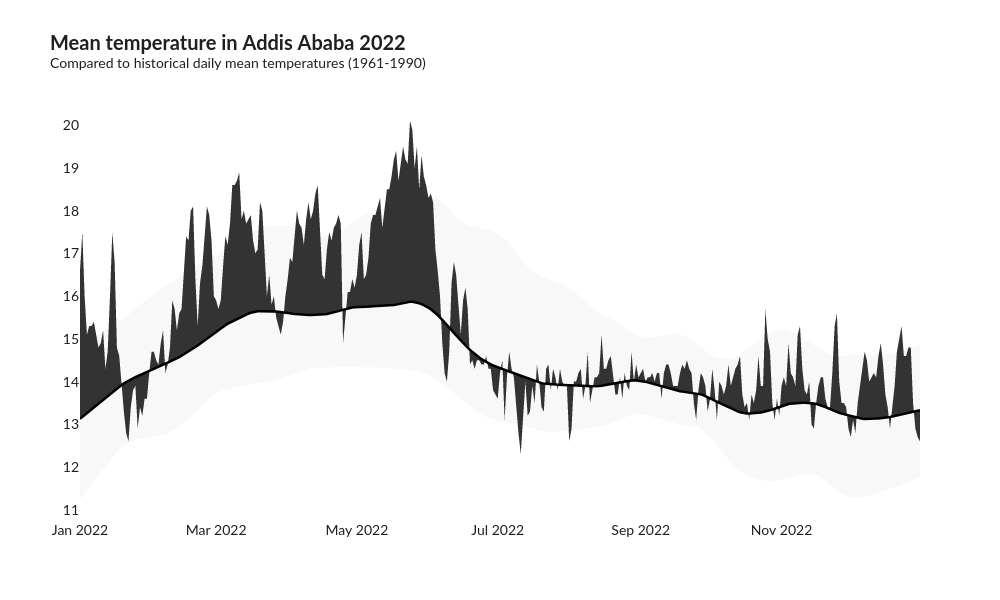

In [48]:
fig.add_traces(
    [
        # Add trace for mean of the reference period
        go.Scatter(
            x=data["date"],
            y=data["mean"],
            name="Mean",
            line={"color": "#000", "width": 2.5},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>Mean {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
        # Add trace for year's values
        go.Scatter(
            name=f"Daily values",
            x=data["date"],
            y=data[f"{year}"],
            line_width=0,
            fill="tonexty",
            fillcolor="#333",
            showlegend=False,
            mode="lines",
        ),
    ]
)

fig.show("png")

Unfortunately, the `fillcolor` option does currently not allow us to provide an array of colors (see [issue on GitHub](https://github.com/plotly/plotly.js/issues/5259)). Instead, we can just asign one fixed color. 

That's why we have to **take a different approach**: We create **one trace for each day of the year**. This way, we can apply opacity and colors for each day of the year. So for each day of the year, we draw a polygon with four points: today's and tomorrow's dates for the x-axis and the respective values for mean and the day's temperature.

In [49]:
# We remove the last two traces added before
fig.data = fig.data[:-2]

## Calculate colorscales

Of course we want the peaks to be displayed in a color, that represents the amount of deviation from the mean value. So we create two colorscales to be used: One for values above the mean and one for values below. We define a function to calculate these colorscales and combine them into one array.

In [50]:
def get_colorscale(series: pd.Series) -> np.ndarray:
    """
    Calculate colorscale for a given series of values.
    """

    # Get difference between year's value and mean of reference period
    diff = series.copy().to_numpy()

    # Create masks for above and below mean
    mask_above = diff > 0
    mask_below = diff < 0

    # Get absolute value of difference
    diff = abs(diff)

    # Create array of zeros with same shape as diff
    diff_norm = np.zeros_like(diff)

    # Calculate min and max for values above the mean
    if len(diff[mask_above]) > 0:
        max_above = np.nanmax(diff[mask_above])
        min_above = np.nanmin(diff[mask_above])

        # Normalize to 0-1
        diff_norm[mask_above] = (diff[mask_above] - min_above) / (max_above - min_above)

    # Calculate min and max for values below the mean
    if len(diff[mask_below]) > 0:
        max_below = np.nanmax(diff[mask_below])
        min_below = np.nanmin(diff[mask_below])

        # Normalize to 0-1
        diff_norm[mask_below] = (diff[mask_below] - min_below) / (max_below - min_below)

    # Create array of white colors with same shape as diff
    colors = np.full_like(diff, "rgb(255, 255, 255)", dtype="object")

    # Sample colors from colormaps, using normalized values
    colors[mask_above] = sample_colorscale("YlOrRd", diff_norm[mask_above])
    colors[mask_below] = sample_colorscale("YlGnBu", diff_norm[mask_below])

    return colors

### Add colored trace for year's values

Now we add one trace for each day and colorize it depending on the difference of each value from the mean.

To get **correct hover infos**, there is one tweak more: We add an invisible trace with the value for the hover info and hide the hover info from the traces added for each day:

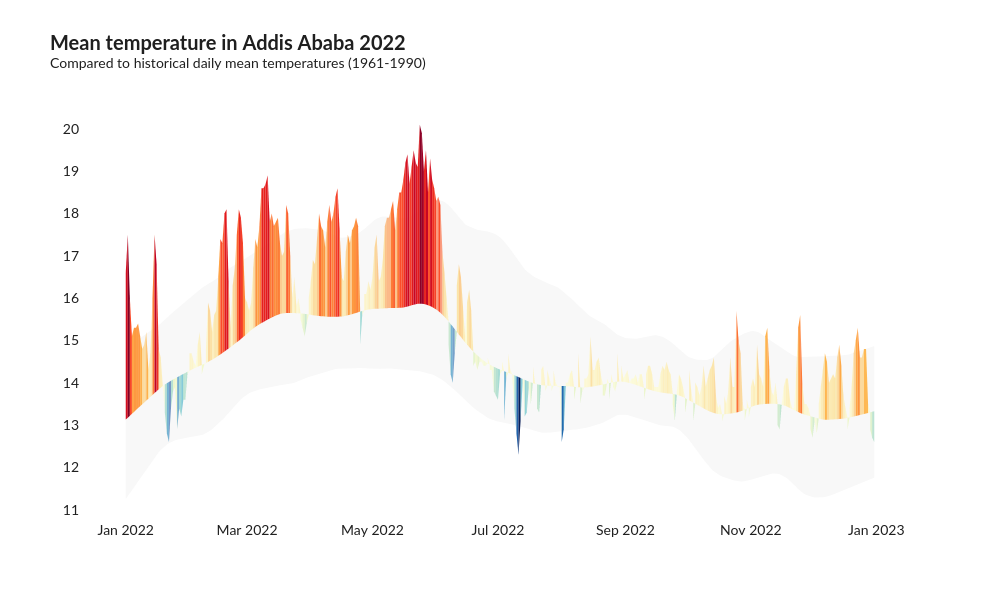

In [51]:
# Get colorscale for year's values
colors = get_colorscale(data[f"{year}_diff"])

# Invisible trace just to show the correct hover info
fig.add_trace(
    go.Scatter(
        x=data["date"],
        y=data[f"{year}"],
        showlegend=False,
        mode="markers",
        name="Hoverinfo current date",
        hovertemplate=("%{y:.1f} °C<extra></extra>"),
        marker={
            "color": colors,  # This color will be shown on hover
            "opacity": 0,  # Hide the marker
        },
    )
)

# For each day, add a filled area between the mean and the year's value
for i in range(len(data) - 1):
    # Define x and y values to draw a polygon between mean and values of today and tomorrow
    date_today = data["date"].iloc[i]
    date_tomorrow = data["date"].iloc[i + 1]
    mean_today = data["mean"].iloc[i]
    mean_tomorrow = data["mean"].iloc[i + 1]
    value_today = data[f"{year}"].iloc[i]
    value_tomorrow = data[f"{year}"].iloc[i + 1]

    # If one day is above and the other below the mean, set the value to the mean
    if (value_today > mean_today) ^ (value_tomorrow > mean_tomorrow):
        value_tomorrow = mean_tomorrow

    fig.add_trace(
        go.Scatter(
            name=f"Daily value {data['date'].iloc[i].strftime('%d.%m.%Y')}",
            x=[date_today, date_today, date_tomorrow, date_tomorrow],
            y=[mean_today, value_today, value_tomorrow, mean_tomorrow],
            line_width=0,
            fill="toself",
            fillcolor=colors[i],
            showlegend=False,
            mode="lines",
            opacity=data[f"{year}_alpha"].iloc[i],
            # Hide the trace from hover info
            hoverinfo="skip",
        )
    )

fig.show("png")

### Plot dotted percentile lines and mean line

Next, we add dotted lines for the percentiles and a solid line for the mean because we want them to appear on top of daily values.

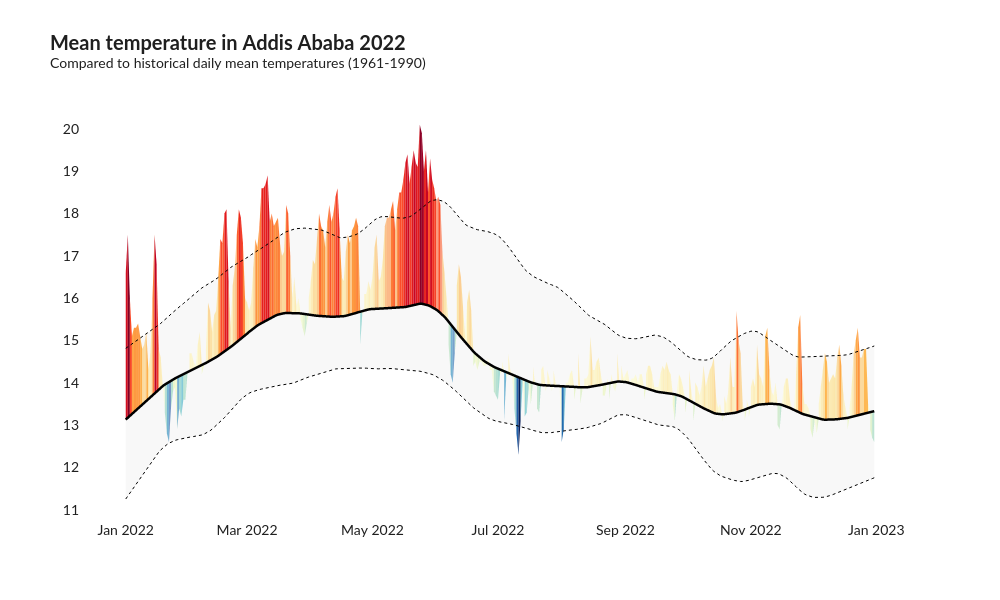

In [52]:
fig.add_traces(
    [
        # p95 trace
        go.Scatter(
            x=data["date"],
            y=data["p95"],
            name="P95",
            line={"color": "#000", "width": 1, "dash": "dot"},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>95th percentile {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
        # Mean trace
        go.Scatter(
            x=data["date"],
            y=data["mean"],
            name="Mean",
            line={"color": "#000", "width": 2.5},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>Mean {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
        # p05 trace
        go.Scatter(
            x=data["date"],
            y=data["p05"],
            name="P05",
            line={"color": "#000", "width": 1, "dash": "dot"},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>5th percentile {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
    ]
)

fig.show("png")

### Add alternating background colors

To make it easier to distinguish values by month, we add alternating background colors for each month.

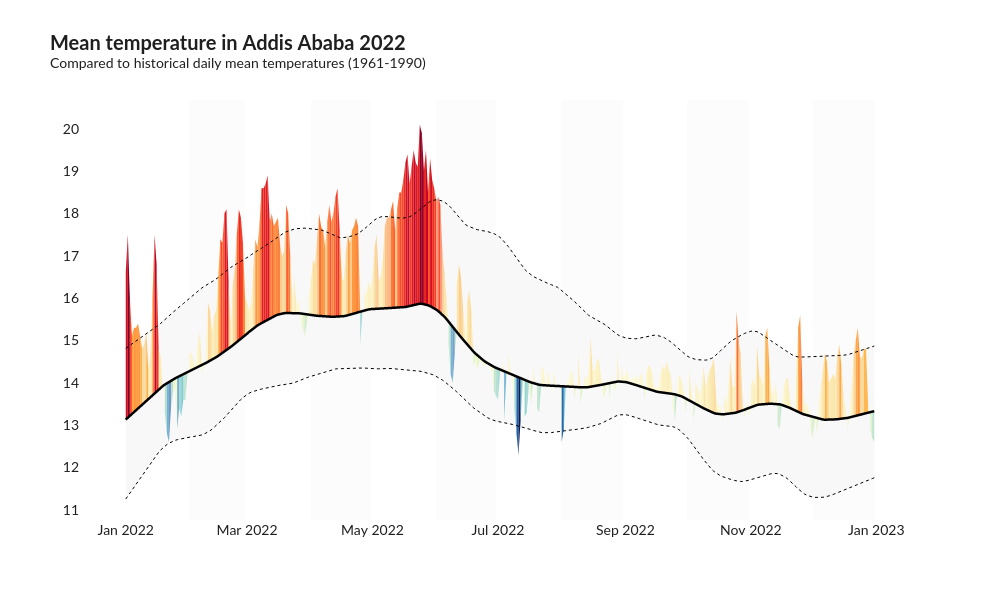

In [53]:
# Define dict with first and last day of each month, ignoring leap days
months_with_days = {
    month: (
        dt.datetime(year, month, 1),
        dt.datetime(
            year, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31
        ),
    )
    for month in range(1, 13)
}

# Loop over months and add a shape for each month
for month, days in months_with_days.items():
    # Define background color
    bg_color = "#fcfcfc" if (month % 2) == 0 else "#fff"

    fig.add_shape(
        type="rect",
        yref="paper",
        x0=days[0],
        x1=days[1],
        y0=0,
        y1=1,
        fillcolor=bg_color,
        layer="below",
        line_width=0,
    )

fig.show("png")

## Add annotations

To make the chart easier to understand, we add some annotations for mean line, percentile area, and percentile lines.

In [ ]:
# Position arrow
arrow_x = dt.datetime.strptime(f"{year}-03-15", "%Y-%m-%d")
arrow_y = data[data["date"] == arrow_x]["mean"].values[0]

# Position text
text_x = dt.datetime.strptime(f"{year}-04-15", "%Y-%m-%d")
text_y = data[data["date"] == text_x]["p05"].values[0] - 2

fig.add_annotation(
    x=arrow_x,
    y=arrow_y,
    xref="x",
    yref="y",
    ax=text_x,
    ay=text_y,
    axref="x",
    ayref="y",
    text=(f"Mean Temperature<br />{reference_period[0]}-{reference_period[1]}"),
    showarrow=True,
    xanchor="center",
    yanchor="middle",
    arrowwidth=2,
    arrowcolor="#000",
    name="Reference period mean",
)

In [ ]:
# Position arrow
arrow_x = dt.datetime.strptime(f"{year}-08-01", "%Y-%m-%d")
arrow_y = data[data["date"] == arrow_x]["p95"].values[0] - 0.5

# Position text
text_x = dt.datetime.strptime(f"{year}-09-15", "%Y-%m-%d")
text_y = data[data["date"] == text_x]["p95"].values[0] + 2

fig.add_annotation(
    x=arrow_x,
    y=arrow_y,
    xref="x",
    yref="y",
    ax=text_x,
    ay=text_y,
    axref="x",
    ayref="y",
    text="90% of reference period<br />values fall within the gray area",
    showarrow=True,
    xanchor="center",
    yanchor="middle",
    arrowwidth=2,
    arrowcolor="#000",
    name="Reference period mean",
)

In [56]:
for percentile in ["p05", "p95"]:
    fig.add_annotation(
        x=data["date"].iloc[-1],
        y=data[percentile].iloc[-1],
        text=percentile.upper(),
        showarrow=False,
        xanchor="left",
        yanchor="middle",
    )

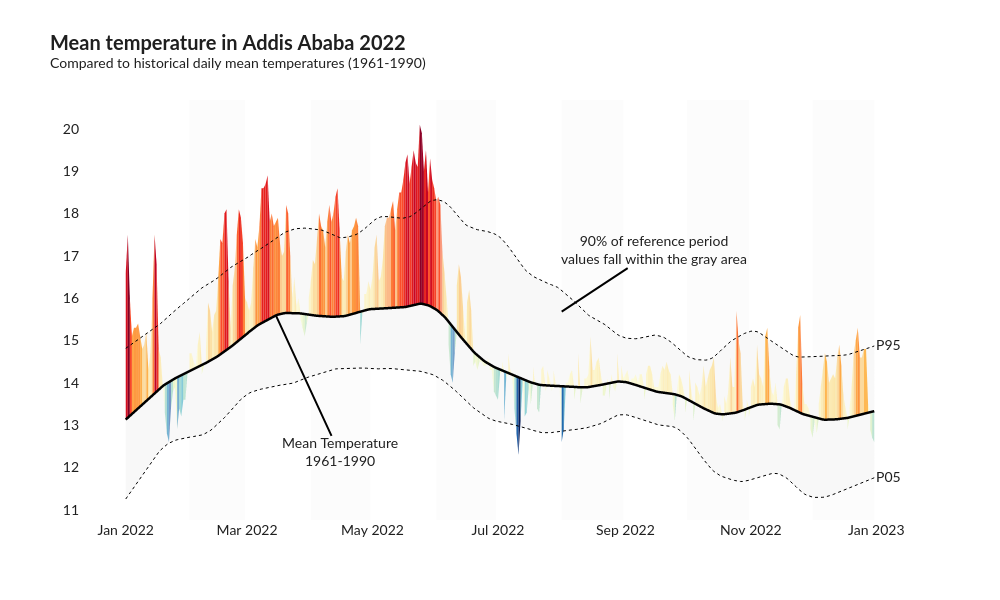

In [57]:
# Show figure
fig.show("png")

### Add data source

Of course we want to attribute the data sources and add the author of the graph, so we add them as annotations.

In [ ]:
fig.add_annotation(
    xref="paper",
    yref="paper",
    name="Data source",
    x=1,
    y=-0.14,
    xanchor="right",
    showarrow=False,
    text="<b>Data:</b> open-meteo.com, OSM, "
    "<b>License:</b> CC by-sa-nc 4.0  "
    "<b>Graph:</b> Jan Kühn, https://yotka.org",
    opacity=0.5,
    font_size=12,
)

## Update layout for final figure

As our last step, we update the layout of the figure to get the look we want.

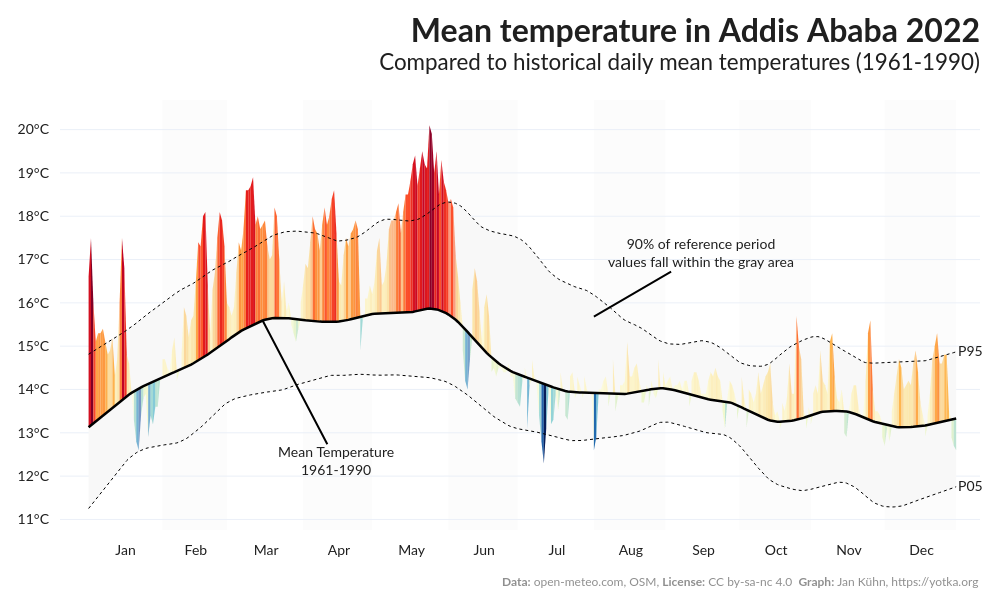

In [59]:
fig.update_layout(
    # Increase font size for title and adjust position
    title={
        "font": {"family": "Lato", "size": 32, "color": "#1f1f1f"},
        "x": 0.98,
        "y": 0.93,
        "xanchor": "right",
        "yanchor": "top",
    },
    margin={"b": 70, "l": 60, "r": 20, "t": 100, "pad": 10},
    xaxis={
        "dtick": "M1",  # Tick every month
        "hoverformat": "%e %B",  # Day and month name
        # Set range to include 10 days before and after the year to have some space
        "range": [f"{year-1}-12-20", f"{year+1}-01-10"],
        "showgrid": False,
        "tickformat": "%b",  # Month name
        "ticklabelmode": "period",  # Center tick labels
    },
    yaxis={"showgrid": True, "ticksuffix": "°C",},
)

fig.show("png")

## Complete code for the plot

In [ ]:
"""
Create a new Figure object with some basic layout
"""

fig = go.Figure(
    layout=go.Layout(
        template="plotly_white",
        title={
            "text": (
                f"<b>Mean temperature in Addis Ababa {year}</b><br />"
                f"<sup>Compared to historical daily mean temperatures "
                f"({reference_period[0]}-{reference_period[1]})</sup>"
            ),
        },
        width=1000,
        height=600,
        font={"family": "Lato", "size": 14, "color": "#1f1f1f"},
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        hovermode="x",
    )
)


"""
Add traces for percentile area
"""

fig.add_traces(
    [
        # p95 trace used as upper bound. This is needed to fill the area between
        # the p05 and p95 traces using the "tonexty" fill option
        go.Scatter(
            x=data["date"],
            y=data["p95"],
            name="Percentile area upper bound (p95)",
            # Make line invisible
            line_color="rgba(0,0,0,0)",
            showlegend=False,
            hoverinfo="skip",
        ),
        # Fill area between p05 and p95
        go.Scatter(
            x=data["date"],
            y=data["p05"],
            name="Area between p05 and p95",
            # Fill area between this trace and the one above
            fill="tonexty",
            fillcolor="#f8f8f8",
            # Make line invisible
            line_color="rgba(0,0,0,0)",
            showlegend=False,
            hoverinfo="skip",
        ),
    ]
)

"""
Add invisible trace just to show the correct hover info
"""

# Get colorscale
colors = get_colorscale(data[f"{year}_diff"])

fig.add_trace(
    go.Scatter(
        x=data["date"],
        y=data[f"{year}"],
        showlegend=False,
        mode="markers",
        name="Hoverinfo current date",
        hovertemplate=("%{y:.1f} °C<extra></extra>"),
        marker={
            "color": colors,  # This color will be shown on hover
            "opacity": 0,  # Hide the marker
        },
    )
)

"""
For each day, add a filled area between the mean and the year's value
"""

for i in range(len(data) - 1):
    # Define x and y values to draw a polygon between mean and values of today and tomorrow
    date_today = data["date"].iloc[i]
    date_tomorrow = data["date"].iloc[i + 1]
    mean_today = data["mean"].iloc[i]
    mean_tomorrow = data["mean"].iloc[i + 1]
    value_today = data[f"{year}"].iloc[i]
    value_tomorrow = data[f"{year}"].iloc[i + 1]

    # If one day is above and the other below the mean, set the value to the mean
    if (value_today > mean_today) ^ (value_tomorrow > mean_tomorrow):
        value_tomorrow = mean_tomorrow

    fig.add_trace(
        go.Scatter(
            name=f"Daily value {data['date'].iloc[i].strftime('%d.%m.%Y')}",
            x=[date_today, date_today, date_tomorrow, date_tomorrow],
            y=[mean_today, value_today, value_tomorrow, mean_tomorrow],
            line_width=0,
            fill="toself",
            fillcolor=colors[i],
            showlegend=False,
            mode="lines",
            opacity=data[f"{year}_alpha"].iloc[i],
            # Hide the trace from hover info
            hoverinfo="skip",
        )
    )


"""
Add traces for mean, p05, and p95 lines
"""

fig.add_traces(
    [
        # p95 trace
        go.Scatter(
            x=data["date"],
            y=data["p95"],
            name="P95",
            line={"color": "#000", "width": 1, "dash": "dot"},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>95th percentile {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
        # Mean trace
        go.Scatter(
            x=data["date"],
            y=data["mean"],
            name="Mean",
            line={"color": "#000", "width": 2.5},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>Mean {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
        # p05 trace
        go.Scatter(
            x=data["date"],
            y=data["p05"],
            name="P05",
            line={"color": "#000", "width": 1, "dash": "dot"},
            showlegend=False,
            hovertemplate=(
                "%{y:.1f} °C"
                f"<extra><b>5th percentile {reference_period[0]}-"
                f"{reference_period[1]}</b></extra>"
            ),
        ),
    ]
)


"""
Add alternating background colors for each month
"""

# Define dict with first and last day of each month, ignoring leap days
months_with_days = {
    month: (
        dt.datetime(year, month, 1),
        dt.datetime(
            year, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31
        ),
    )
    for month in range(1, 13)
}

# Loop over months and add a shape for each month
for month, days in months_with_days.items():
    # Define background color
    bg_color = "#fcfcfc" if (month % 2) == 0 else "#fff"

    fig.add_shape(
        type="rect",
        yref="paper",
        x0=days[0],
        x1=days[1],
        y0=0,
        y1=1,
        fillcolor=bg_color,
        layer="below",
        line_width=0,
    )


"""
Add annotation for mean line
"""

# Position arrow
arrow_x = dt.datetime.strptime(f"{year}-03-15", "%Y-%m-%d")
arrow_y = data[data["date"] == arrow_x]["mean"].values[0]

# Position text
text_x = dt.datetime.strptime(f"{year}-04-15", "%Y-%m-%d")
text_y = data[data["date"] == text_x]["p05"].values[0] - 2

fig.add_annotation(
    x=arrow_x,
    y=arrow_y,
    xref="x",
    yref="y",
    ax=text_x,
    ay=text_y,
    axref="x",
    ayref="y",
    text=(f"Mean Temperature<br />{reference_period[0]}-{reference_period[1]}"),
    showarrow=True,
    xanchor="center",
    yanchor="middle",
    arrowwidth=2,
    arrowcolor="#000",
    name="Reference period mean",
)


"""
Add annotation for percentile area
"""

# Position arrow
arrow_x = dt.datetime.strptime(f"{year}-08-01", "%Y-%m-%d")
arrow_y = data[data["date"] == arrow_x]["p95"].values[0] - 0.5

# Position text
text_x = dt.datetime.strptime(f"{year}-09-15", "%Y-%m-%d")
text_y = data[data["date"] == text_x]["p95"].values[0] + 2

fig.add_annotation(
    x=arrow_x,
    y=arrow_y,
    xref="x",
    yref="y",
    ax=text_x,
    ay=text_y,
    axref="x",
    ayref="y",
    text="90% of reference period<br />values fall within the gray area",
    showarrow=True,
    xanchor="center",
    yanchor="middle",
    arrowwidth=2,
    arrowcolor="#000",
    name="Reference period mean",
)


"""
Add annotations for percentile lines
"""

for percentile in ["p05", "p95"]:
    fig.add_annotation(
        x=data["date"].iloc[-1],
        y=data[percentile].iloc[-1],
        text=percentile.upper(),
        showarrow=False,
        xanchor="left",
        yanchor="middle",
    )


"""
Add annotation for data source
"""

fig.add_annotation(
    xref="paper",
    yref="paper",
    name="Data source",
    x=1,
    y=-0.14,
    xanchor="right",
    showarrow=False,
    text="<b>Data:</b> open-meteo.com, OSM, "
    "<b>License:</b> CC by-sa-nc 4.0  "
    "<b>Graph:</b> Jan Kühn, https://yotka.org",
    opacity=0.5,
    font_size=12,
)


"""
Adjust layout
"""

fig.update_layout(
    # Increase font size for title and adjust position
    title={
        "font": {"family": "Lato", "size": 32, "color": "#1f1f1f"},
        "x": 0.98,
        "y": 0.93,
        "xanchor": "right",
        "yanchor": "top",
    },
    margin={"b": 70, "l": 60, "r": 20, "t": 100, "pad": 10},
    xaxis={
        "dtick": "M1",  # Tick every month
        "hoverformat": "%e %B",  # Day and month name
        "range": [f"{year-1}-12-20", f"{year+1}-01-10"],
        "showgrid": False,
        "tickformat": "%b",  # Month name
        "ticklabelmode": "period",  # Center tick labels
    },
    yaxis={"showgrid": True, "ticksuffix": "°C",},
)

In [70]:
# Resize and save interactive plot as a standalone HTML file
fig.update_layout(width=800, height=480)
fig.write_html(
    "../../static/interactiveCharts/524-plotly-area-over-flexible-baseline.html"
)

Display it inside an iFrame:

In [71]:
%%html
<iframe src="../../static/interactiveCharts/524-plotly-area-over-flexible-baseline.html" width="840" height="504" title="Area over flexible baseline" style="border:none"></iframe>